In [1]:
import pandas as pd

In [2]:
# Read the CSV files
cal = pd.read_csv('data/raw/calendar2024.csv')
lis = pd.read_csv('data/raw/listings2024.csv') 
rev = pd.read_csv('data/raw/reviews2024.csv')
print("Listings shape:", lis.shape)
print("Calendar shape:", cal.shape) 
print("Reviews shape:", rev.shape)

Listings shape: (20909, 75)
Calendar shape: (7631731, 7)
Reviews shape: (366636, 6)


## TODO
- [ ] Many variables are stored as generic objects, instead of their actual datatype
- [ ] datetime columns are stored as objects
- [ ] lis.neighbourhood_cleansed has spelling mistakes
- [ ] first name of reviewer/host seems irrelevant, when unique-ID is available
- [ ] NaN, missing, and null values are inconsistent
- [ ] Boolean is expressed as t/f
- [ ] Price is stored as a string in an arbitrary currency (is it $ or local?)
- [ ] lis csv. host_verifications, and amenities are categorical, but are stored as objects. Depending on how many amenities there are, it may/may not be better to store as a categorical – but host_verification is a short enough list. Same goes for source.

**lis csv** 
- property_type, and room_type are mapped as obj., is categorial
- bathroom and bathrooms_text are the same, but bathrooms_text has some values that are not in bathroom.
- bedrooms, and beds	are stored as float, but is int.

- [ ] ETL: Extract, Transform, Load

---
> Attributes of datasets identified at initial look
- Primary keys: cal.listing_id, list.id, rev.listing_id


# Clean

In [3]:
null_cols_lis = lis.columns[lis.isna().all()].tolist()
lis = lis.drop(columns=null_cols_lis)

lis.drop(columns=['scrape_id', 'host_name', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url'], inplace=True)
cal.drop(columns=['adjusted_price'], inplace=True)
rev.drop(columns=['reviewer_name'], inplace=True)


def convert_to_boolean(df, columns, true_value='t'):
    """Convert specified columns from string indicators to boolean"""
    for col in columns:
        df[col] = df[col] == true_value
    return df

boolean_cols = ['instant_bookable', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability']
lis = convert_to_boolean(lis, boolean_cols)
cal['available'] = cal['available'] == 't'


def convert_to_datetime(df, columns):
    """Convert specified columns to datetime"""
    for col in columns:
        df[col] = pd.to_datetime(df[col])
    return df

datetime_cols_lis = ['calendar_last_scraped', 'first_review', 'last_review', 'last_scraped', 'host_since']
lis = convert_to_datetime(lis, datetime_cols_lis)
cal['date'] = pd.to_datetime(cal['date'])
rev['date'] = pd.to_datetime(rev['date'])


def convert_to_type(df, columns, dtype):
    """Convert specified columns to given dtype"""
    for col in columns:
        df[col] = df[col].astype(dtype)
    return df

string_columns = ['bathrooms_text', 'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type', 'host_location', 'host_about', 'host_neighbourhood', 'listing_url', 'host_response_time', 'source', 'name','description','neighborhood_overview']
lis = convert_to_type(lis, string_columns, "string")
rev['comments'] = rev['comments'].astype("string")


percentage_cols = ['host_response_rate', 'host_acceptance_rate']
for col in percentage_cols:
    lis = lis.rename(columns={col: f"{col}_pct"})
    lis[f"{col}_pct"] = lis[f"{col}_pct"].str.rstrip('%').astype('float') / 100

# Currency inconsistency adjustment
lis['price'] = lis['price'].str.replace(r'[\$,]', '', regex=True)
lis = lis.rename(columns={'price': 'price_DKK'})
lis['price_DKK'] = pd.to_numeric(lis['price_DKK'], errors='coerce')

cal['price'] = cal['price'].str.replace(r'[\$,]', '', regex=True)
cal = cal.rename(columns={'price': 'price_USD'})
cal['price_USD'] = pd.to_numeric(cal['price_USD'], errors='coerce')

########## Handling list columns ##########

lis['amenities_count'] = lis.amenities.str.strip('[]').str.split(',').str.len()


def clean_amenity(text):
    """Clean individual amenity strings"""
    import re
    text = str(text) # Convert to string if not already
    text = text.strip().strip('"\'').strip('.- ') # Basic cleaning
    text = text.encode('ascii', 'ignore').decode('ascii') # Replace unicode escape sequences with their characters
    text = re.sub(r'\s+', ' ', text) # Replace multiple spaces with single space
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters, keeping only alphanumeric and spaces
    text = text.lower().strip() # Convert to lowercase, strip again, and remove any remaining leading/trailing spaces
    return text

# Clean and convert amenities to comma-separated string
lis['amenities'] = lis['amenities'].str.strip('[]').str.split(',').apply(
    lambda x: ','.join(
        sorted(  # Sort for consistency
            filter(None,  # Remove empty strings
                [clean_amenity(item) for item in x]
            )
        )
    )
)

lis['amenities'] = lis['amenities'].astype('string') # Convert to string dtype

# Count number of verifications per host
lis['host_verifications_count'] = lis['host_verifications'].str.strip('[]').str.split(', ').str.len()
lis['host_verifications'] = lis['host_verifications'].str.strip('[]').str.replace("'", "").str.split(', ')
# Create one-hot encoded columns
verification_dummies = lis['host_verifications'].str.join('|').str.get_dummies()
verification_dummies = verification_dummies.add_prefix('verification_')
lis = pd.concat([lis, verification_dummies], axis=1)

lis.drop(columns=['host_verifications', 'amenities'], inplace=True)

print("Listings shape:", lis.shape)
print("Calendar shape:", cal.shape) 
print("Reviews shape:", rev.shape)

Listings shape: (20909, 70)
Calendar shape: (7631731, 6)
Reviews shape: (366636, 5)


In [6]:
# Save processed datasets
lis.to_parquet('data/processed/02_listings.parquet')
cal.to_parquet('data/processed/02_calendar.parquet')
rev.to_parquet('data/processed/02_reviews.parquet')

In [ ]:
# read to regular df, and maintain original Dtypes
lis2 = pd.read_parquet('data/processed/02_listings.parquet')
cal2 = pd.read_parquet('data/processed/02_calendar.parquet')
rev2 = pd.read_parquet('data/processed/02_reviews.parquet')

In [4]:
lis.head()

,id,listing_url,last_scraped,source,name,description,neighborhood_overview,host_id,host_since,host_location,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenities_count,host_verifications_count,verification_email,verification_phone,verification_photographer,verification_work_email
0,31094,https://www.airbnb.com/rooms/31094,2024-06-30,previous scrape,"Beautiful, spacious, central, renovated Penthouse","Welcome to our home, we hope you will enjoy Wo...","What else is nearby?<br />To be honest, We thi...",129976,2010-05-22,"Copenhagen, Denmark",...,1,0,0,0.11,56,2.0,1,1,0,0
1,262961,https://www.airbnb.com/rooms/262961,2024-06-30,city scrape,192m2 FLAT+ 8m2 BALCONY IN CENTER NØRREBRO HOOD,If you are looking for a large apartment in ce...,TIME OUT - The world’s coolest neighbourhoods ...,1379904,2011-11-07,"Copenhagen, Denmark",...,1,0,0,0.24,46,2.0,1,1,0,0
2,263036,https://www.airbnb.com/rooms/263036,2024-06-30,city scrape,Bright flat in central location,<NA>,<NA>,1232471,2011-10-01,"Copenhagen, Denmark",...,1,0,0,0.14,16,2.0,1,1,0,0
3,32379,https://www.airbnb.com/rooms/32379,2024-06-30,city scrape,"155 m2 artist flat on Vesterbro, with 2 bathrooms",You enter a narrow entrance and feel the good ...,"Værnedamsvej area is super hip area, we call i...",140105,2010-06-07,"Copenhagen, Denmark",...,1,1,0,0.49,43,2.0,1,1,0,0
4,263708,https://www.airbnb.com/rooms/263708,2024-06-30,city scrape,Urban garden on Vesterbro rooftop,<NA>,<NA>,1383888,2011-11-08,"Copenhagen, Denmark",...,1,0,0,0.02,35,3.0,1,1,0,1


In [122]:
# Count amenities and add new column
lis['amenities_count'] = lis.amenities.str.strip('[]').str.split(',').str.len()

lis.amenities.str.strip('[]').str.split(',')

# lis['amenities'] = lis['amenities'].str.strip('[]').str.replace("'", "")
# Encoding host_verifications
# First clean up the string representation of lists

In [ ]:
# Using PostgreSQL COPY command
# COPY table_name TO 'output.csv' WITH (FORMAT CSV, HEADER);


In [5]:
lis.dtypes.value_counts()

int64             25
float64           21
string[python]    14
datetime64[ns]     5
bool               5
Name: count, dtype: int64

In [41]:
lis.host_verifications

0                      ['email', 'phone']
1                      ['email', 'phone']
2                      ['email', 'phone']
3                      ['email', 'phone']
4        ['email', 'phone', 'work_email']
                       ...               
20904                           ['phone']
20905                  ['email', 'phone']
20906                  ['email', 'phone']
20907                  ['email', 'phone']
20908                  ['email', 'phone']
Name: host_verifications, Length: 20909, dtype: object

---

In [44]:
lis[lis.columns[-10:]]#.info()

,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenities_count,verification_email,verification_phone,verification_photographer,verification_work_email
0,1,1,0,0,0.11,56,1,1,0,0
1,1,1,0,0,0.24,46,1,1,0,0
2,1,1,0,0,0.14,16,1,1,0,0
3,2,1,1,0,0.49,43,1,1,0,0
4,1,1,0,0,0.02,35,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
20904,1,1,0,0,NaN,6,0,1,0,0
20905,1,1,0,0,NaN,5,1,1,0,0
20906,1,1,0,0,NaN,6,1,1,0,0
20907,1,1,0,0,NaN,29,1,1,0,0


In [26]:
lis[lis.columns[-20:]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20909 entries, 0 to 20908
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   availability_365                              20909 non-null  int64         
 1   calendar_last_scraped                         20909 non-null  datetime64[ns]
 2   number_of_reviews                             20909 non-null  int64         
 3   number_of_reviews_ltm                         20909 non-null  int64         
 4   number_of_reviews_l30d                        20909 non-null  int64         
 5   first_review                                  17689 non-null  datetime64[ns]
 6   last_review                                   17689 non-null  datetime64[ns]
 7   review_scores_rating                          17689 non-null  float64       
 8   review_scores_accuracy                        17665 non-null  floa

In [25]:
lis.iloc[:10, 40:]

,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3.0,10.0,True,0,0,0,0,2024-06-30,19,0,...,4.87,4.82,4.80,4.53,False,1,1,0,0,0.11
1,5.0,90.0,True,0,0,0,0,2024-06-30,36,2,...,4.94,4.94,4.89,4.53,False,1,1,0,0,0.24
2,4.0,10.0,True,0,4,32,32,2024-06-30,21,1,...,4.86,4.86,4.81,4.67,False,1,1,0,0,0.14
3,3.0,9.0,True,18,22,22,22,2024-06-30,82,3,...,4.88,4.91,4.89,4.71,False,2,1,1,0,0.49
4,7.0,60.0,True,10,17,45,45,2024-06-30,3,0,...,5.00,5.00,4.67,4.00,False,1,1,0,0,0.02
5,2.0,1125.0,False,0,0,0,0,2024-06-30,4,0,...,4.67,4.00,4.25,3.50,False,4,0,2,2,0.03
6,100.0,1125.0,True,0,0,0,0,2024-06-30,7,0,...,5.00,5.00,4.50,4.50,False,1,1,0,0,0.04
7,6.0,220.0,True,0,0,0,266,2024-06-30,17,0,...,4.35,4.65,4.71,4.24,False,1,1,0,0,0.12
8,3.0,14.0,True,1,1,1,1,2024-06-30,58,0,...,4.98,4.93,4.61,4.63,False,1,1,0,0,0.39
9,5.0,1125.0,True,0,7,20,20,2024-06-30,24,9,...,4.72,5.00,4.89,4.83,False,1,1,0,0,0.14


In [56]:
lis[lis.columns[10:20]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20909 entries, 0 to 20908
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   host_since            20908 non-null  datetime64[ns]
 1   host_location         17480 non-null  object        
 2   host_about            8866 non-null   object        
 3   host_response_time    14441 non-null  object        
 4   host_response_rate    14441 non-null  object        
 5   host_acceptance_rate  17161 non-null  object        
 6   host_is_superhost     20909 non-null  bool          
 7   host_thumbnail_url    20908 non-null  object        
 8   host_picture_url      20908 non-null  object        
 9   host_neighbourhood    5417 non-null   object        
dtypes: bool(1), datetime64[ns](1), object(8)
memory usage: 1.5+ MB


In [14]:
lis[lis.columns[10:20]]

,host_about,host_response_time,host_response_rate_pct,host_acceptance_rate_pct,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic
0,"Hi and welcome. My name is Ebbe, I am a medica...",<NA>,NaN,NaN,False,Vesterbro,1.0,1.0,"['email', 'phone']",True
1,Hej - I read the Master in Pedagogy. My husba...,<NA>,NaN,1.0,False,Nørrebro,1.0,3.0,"['email', 'phone']",True
2,"Bla, bla, bla, bla",within a few hours,1.0,0.0,False,Nørrebro,1.0,1.0,"['email', 'phone']",True
3,As profession - Set and Costumedesigner for Av...,within an hour,1.0,1.0,True,Vesterbro,3.0,4.0,"['email', 'phone']",True
4,<NA>,within a day,0.9,0.0,False,Vesterbro,1.0,1.0,"['email', 'phone', 'work_email']",True
...,...,...,...,...,...,...,...,...,...,...
20904,<NA>,<NA>,NaN,NaN,False,<NA>,1.0,1.0,['phone'],True
20905,We're a 'young' (32 and 34) couple from Denmar...,<NA>,NaN,NaN,False,<NA>,1.0,1.0,"['email', 'phone']",False
20906,-,<NA>,NaN,NaN,False,<NA>,1.0,5.0,"['email', 'phone']",True
20907,"Hej, jeg er Razan Haugaard, en 51-årig selvstæ...",<NA>,NaN,NaN,False,<NA>,1.0,4.0,"['email', 'phone']",True


---

## Amenity analysis

In [ ]:
# Define key amenity categories that are most relevant for pricing/booking
IMPORTANT_AMENITIES = {
    'essentials': ['Wifi', 'Kitchen', 'Heating', 'Air conditioning', 'Washer'],
    'luxury': ['Pool', 'Hot tub', 'Gym', 'Free parking'],
    'safety': ['Smoke alarm', 'Carbon monoxide alarm', 'Fire extinguisher']
}

# Create binary columns for important amenities and category counts
for category, items in IMPORTANT_AMENITIES.items():
    # Create binary columns for each important amenity
    for item in items:
        lis[f'has_{item.lower().replace(" ", "_")}'] = lis['amenities'].str.contains(item, case=False)
    
    # Create count for each category
    lis[f'{category}_count'] = lis['amenities'].apply(
        lambda x: sum(item.lower() in x.lower() for item in items)
    )

In [112]:
lis['amenities']

0        ["Toaster", "Refrigerator", "Conditioner", "Ho...
1        ["Refrigerator", "Fire extinguisher", "Hot wat...
2        ["Carbon monoxide alarm", "Backyard", "Kitchen...
3        ["Carbon monoxide alarm", "Toaster", "Self che...
4        ["Refrigerator", "Hot water", "Oven", "Paid pa...
                               ...                        
20904    ["Kitchen", "TV", "Washer", "Smoke alarm", "Pa...
20905    ["Kitchen", "TV", "Washer", "Smoke alarm", "Wi...
20906    ["Kitchen", "TV", "Washer", "Smoke alarm", "Pa...
20907    ["Refrigerator", "Conditioner", "TV", "Hot wat...
20908                                  ["Kitchen", "Wifi"]
Name: amenities, Length: 20909, dtype: object

In [115]:
# Get all unique amenities
all_amenities = set()
# lis['amenities'].str.split(',').apply(lambda x: [all_amenities.add(item.strip()) for item in x])
lis['amenities'].str.strip('[]').str.split(',').apply(lambda x: [all_amenities.add(item.strip()) for item in x])

# Sort and print the unique amenities to review
sorted_amenities = sorted(all_amenities)

print(f"Total unique amenities: {len(sorted_amenities)}")
print("\nAll unique amenities:")
for amenity in sorted_amenities:
    print(f"- {amenity}")

Total unique amenities: 3649

All unique amenities:
- 
- " Bang & Olufsen Bluetooth sound system"
- " Neutral body soap"
- "- body soap"
- ". body soap"
- ". conditioner"
- ". refrigerator"
- ". shampoo"
- ".. body soap"
- ".. conditioner"
- ".. oven"
- ".. shampoo"
- "... electric stove"
- "... refrigerator"
- "... stainless steel single oven"
- "0 % fragrances body soap"
- "0 % fragrances shampoo"
- "1 hylde til g\u00e6st refrigerator"
- "1 inch HDTV"
- "1 inch TV with Netflix"
- "100 inch HDTV with Apple TV
- "100 inch HDTV with HBO Max
- "100 inch HDTV with Netflix
- "100 inch HDTV with standard cable"
- "100 inch HDTV"
- "110 inch TV with Netflix
- "120 inch HDTV with Chromecast
- "120 inch TV with HBO Max"
- "150 inch HDTV with Apple TV
- "150 inch HDTV with Chromecast"
- "150 inch TV with Apple TV
- "18 inch HDTV with premium cable
- "18 inch TV with Chromecast
- "2 induction hobs induction stove"
- "2 k\u00f8leskab refrigerator"
- "20 inch HDTV with Netflix
- "20 inch TV with A

In [116]:
# Get all unique amenities
all_amenities = set()

# Clean the string representation and split
lis['amenities'].str.strip('[]').str.split(',').apply(
    lambda x: [all_amenities.add(
        # Clean each amenity string:
        item.strip().strip('"\'').strip('.- ').lower()  # Remove quotes, dashes, dots, and extra spaces
    ) for item in x]
)

# Sort and print the unique amenities to review
sorted_amenities = sorted(all_amenities)
print(f"Total unique amenities: {len(sorted_amenities)}")
print("\nAll unique amenities:")
for amenity in sorted_amenities:
    print(f"- {amenity}")

Total unique amenities: 3337

All unique amenities:
- 
- 0 % fragrances body soap
- 0 % fragrances shampoo
- 0% colourant
- 0% colourants
- 0% perfume body soap
- 0%perfume body soap
- 1 hylde til g\u00e6st refrigerator
- 1 inch hdtv
- 1 inch tv with netflix
- 100 inch hdtv
- 100 inch hdtv with apple tv
- 100 inch hdtv with hbo max
- 100 inch hdtv with netflix
- 100 inch hdtv with standard cable
- 110 inch tv with netflix
- 120 inch hdtv with chromecast
- 120 inch tv with hbo max
- 150 inch hdtv with apple tv
- 150 inch hdtv with chromecast
- 150 inch tv with apple tv
- 18 inch hdtv with premium cable
- 18 inch tv with chromecast
- 2 days a week - available at extra cost
- 2 induction hobs induction stove
- 2 k\u00f8leskab refrigerator
- 2-5 years old
- 20 inch hdtv with netflix
- 20 inch tv
- 20 inch tv with apple tv
- 20 inch tv with chromecast
- 200 inch hdtv with chromecast
- 200 inch tv
- 21 inch hdtv with chromecast
- 21 inch hdtv with netflix
- 21 inch tv with chromecast
- 22 in

In [ ]:
# lis['amenities'].str.strip('[]').str.split(',').apply(
#     lambda x: [all_amenities.add(
#         # Clean each amenity string:
#         item.strip().strip('"\'').strip('.- ').lower()  # Remove quotes, dashes, dots, and extra spaces
#     ) for item in x])

def clean_amenity(text):
    """Clean individual amenity strings"""
    import re
    text = str(text) # Convert to string if not already
    text = text.strip().strip('"\'').strip('.- ') # Basic cleaning
    text = text.encode('ascii', 'ignore').decode('ascii') # Replace unicode escape sequences with their characters
    text = re.sub(r'\s+', ' ', text) # Replace multiple spaces with single space
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters, keeping only alphanumeric and spaces
    text = text.lower().strip() # Convert to lowercase, strip again, and remove any remaining leading/trailing spaces
    return text

# Clean and convert amenities to comma-separated string
lis['amenities'] = lis['amenities'].str.strip('[]').str.split(',').apply(
    lambda x: ','.join(
        sorted(  # Sort for consistency
            filter(None,  # Remove empty strings
                [clean_amenity(item) for item in x]
            )
        )
    )
)

lis['amenities'] = lis['amenities'].astype('string') # Convert to string dtype

# Get all unique amenities for sanity check
all_amenities = set()
lis['amenities'].str.strip('[]').str.split(',').apply(
    lambda x: [all_amenities.add(clean_amenity(item)) for item in x if clean_amenity(item)]
)
all_amenities.discard('') # Remove empty strings if any made it through

# Sort and print the unique amenities to review
sorted_amenities = sorted(all_amenities)
print(f"Total unique amenities: {len(sorted_amenities)}")
print("\nAll unique amenities:")
for amenity in sorted_amenities:
    print(f"- {amenity}")

# # Clean and convert amenities to comma-separated string
# lis['amenities'] = lis['amenities'].str.strip('[]').str.split(',').apply(
#     lambda x: ','.join(
#         sorted(  # Sort for consistency
#             filter(None, # Remove empty strings
#                 [clean_amenity(item) for item in x]
#             )
#         )
#     )
# )


# # Display a few examples of the cleaned amenities
# print("Sample of cleaned amenities:")
# print(lis['amenities'][:10])

Total unique amenities: 2816

All unique amenities:
- a brand stove
- a derma
- aamanns botanical senses conditioner
- ac split type ductless system
- acqua di parma conditioner
- acqua di parma shampoo
- active speaker with minijack input sound system with aux
- adam bluetooth sound system
- aderma body soap
- aeg brand new xl size refrigerator
- aeg electric stove
- aeg gas stove
- aeg induction stove
- aeg induktion stove
- aeg oven
- aeg refrigerator
- aeg single oven
- aeg stainless steel double oven
- aeg stainless steel electric stove
- aeg stainless steel gas stove
- aeg stainless steel induction stove
- aeg stainless steel oven
- aeg stainless steel single oven
- aeg stainless steel stove
- aeg stove
- aeg varmluft og dampovn
- aesop body soap
- aesop conditioner
- aesop le labo shampoo
- aesop shampoo
- agroove
- air conditioning
- airfryer oven
- airplay bluetooth sound system
- airplay sound system
- airplay sound system with bluetooth and aux
- airport express bo speakers 

In [130]:
lis['amenities']

0        baby bath,baking sheet,barbecue utensils,bed l...
1        baby bath,babysitter recommendations,baking sh...
2        backyard,bed linens,carbon monoxide alarm,esse...
3        bathtub,bed linens,carbon monoxide alarm,child...
4        baby bath,bbq grill,bed linens,childrenu2019s ...
                               ...                        
20904    kitchen,paid parking on premises,smoke alarm,t...
20905                   kitchen,smoke alarm,tv,washer,wifi
20906    kitchen,paid parking on premises,smoke alarm,t...
20907    beach access u2013 beachfront,bed linens,body ...
20908                                         kitchen,wifi
Name: amenities, Length: 20909, dtype: string

In [124]:
len(all_amenities)

2823

In [103]:
print(lis.amenities.str.strip('[]').str.split(',').str.len().max())

95


In [ ]:
print(cal.price.unique())#.nunique())
lis.dtypes.value_counts()

## Checking currency inconsistency in cal and lis csvs

In [ ]:
cal.loc[cal['listing_id'] == 262961]

,listing_id,date,available,price_USD,minimum_nights,maximum_nights
7203586,262961,2024-06-30,False,250.0,5.0,90.0
7203587,262961,2024-07-01,False,250.0,5.0,90.0
7203588,262961,2024-07-02,False,250.0,5.0,90.0
7203589,262961,2024-07-03,False,250.0,5.0,90.0
7203590,262961,2024-07-04,False,250.0,5.0,90.0
...,...,...,...,...,...,...
7203946,262961,2025-06-25,False,250.0,5.0,90.0
7203947,262961,2025-06-26,False,250.0,5.0,90.0
7203948,262961,2025-06-27,False,250.0,5.0,90.0
7203949,262961,2025-06-28,False,250.0,5.0,90.0


In [ ]:
lis.loc[lis['id'] == 7631726, ['id', 'price_DKK']]

,id,price_DKK


In [ ]:
lis[['id','listing_url', 'price_DKK']][:2]
# calendar_df[calendar_df['listing_id'] == 31094]

,id,listing_url,price_DKK
0,31094,https://www.airbnb.com/rooms/31094,NaN
1,262961,https://www.airbnb.com/rooms/262961,1865.0


---

In [ ]:
lis = lis.where(pd.notnull(lis), None)

In [ ]:
# Sanity check
# print("Calendar date range:", cal['datetime'].min(), "to", cal['datetime'].max())

Python type: <class 'pandas.core.series.Series'>
Pandas dtype: string


In [ ]:
# Get columns with less than 3 unique values
low_unique_cols = [col for col in lis.columns if lis[col].nunique() < 3]
print("Columns with less than 3 unique values:")
for col in low_unique_cols:
    print(f"{col}: {lis[col].nunique()}")

In [ ]:
# print(rev.reviewer_name)#.nunique())
rev.describe()

---

# 01_init_EDA

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
lis_df = pd.read_parquet('data/processed/02_listings.parquet')
cal_df = pd.read_parquet('data/processed/02_calendar.parquet')
rev_df = pd.read_parquet('data/processed/02_reviews.parquet')

### 2. Initial Data Preview

In [10]:
lis_df.head()

,id,listing_url,last_scraped,source,name,description,neighborhood_overview,host_id,host_since,host_location,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenities_count,host_verifications_count,verification_email,verification_phone,verification_photographer,verification_work_email
0,31094,https://www.airbnb.com/rooms/31094,2024-06-30,previous scrape,"Beautiful, spacious, central, renovated Penthouse","Welcome to our home, we hope you will enjoy Wo...","What else is nearby?<br />To be honest, We thi...",129976,2010-05-22,"Copenhagen, Denmark",...,1,0,0,0.11,56,2.0,1,1,0,0
1,262961,https://www.airbnb.com/rooms/262961,2024-06-30,city scrape,192m2 FLAT+ 8m2 BALCONY IN CENTER NØRREBRO HOOD,If you are looking for a large apartment in ce...,TIME OUT - The world’s coolest neighbourhoods ...,1379904,2011-11-07,"Copenhagen, Denmark",...,1,0,0,0.24,46,2.0,1,1,0,0
2,263036,https://www.airbnb.com/rooms/263036,2024-06-30,city scrape,Bright flat in central location,<NA>,<NA>,1232471,2011-10-01,"Copenhagen, Denmark",...,1,0,0,0.14,16,2.0,1,1,0,0
3,32379,https://www.airbnb.com/rooms/32379,2024-06-30,city scrape,"155 m2 artist flat on Vesterbro, with 2 bathrooms",You enter a narrow entrance and feel the good ...,"Værnedamsvej area is super hip area, we call i...",140105,2010-06-07,"Copenhagen, Denmark",...,1,1,0,0.49,43,2.0,1,1,0,0
4,263708,https://www.airbnb.com/rooms/263708,2024-06-30,city scrape,Urban garden on Vesterbro rooftop,<NA>,<NA>,1383888,2011-11-08,"Copenhagen, Denmark",...,1,0,0,0.02,35,3.0,1,1,0,1


In [11]:
cal_df.head()

,listing_id,date,available,price_USD,minimum_nights,maximum_nights
0,586421,2024-06-30,False,250.0,4.0,31.0
1,586421,2024-07-01,False,250.0,4.0,31.0
2,586421,2024-07-02,True,250.0,4.0,31.0
3,586421,2024-07-03,False,250.0,4.0,31.0
4,586421,2024-07-04,False,250.0,4.0,31.0


In [12]:
rev_df.head()

,listing_id,id,date,reviewer_id,comments
0,31094,79346,2010-08-16,171607,"We had a great stay. Conveniently located, qui..."
1,31094,166275,2011-01-05,306860,It was a very good stay. The appartment was re...
2,31094,1452299,2012-06-10,1321058,Really enjoyed my time at Ebbe's place. It is...
3,31094,6766430,2013-08-24,2182771,"The apartment was very well located, 10-15 min..."
4,31094,6827217,2013-08-26,8025926,"This is a great flat, very clean with everythi..."


### 3. Data Structure Analysis

In [13]:
def explore_dataset(df, name):
    print(f"\n{'='*50}")
    print(f"Dataset: {name}")
    print(f"{'='*50}")
    
    print("\n1. Basic Information:")
    print(f"Shape: {df.shape}")
    
    print("\n2. Data Types:")
    print(df.dtypes)

    print("\n3. Summary Statistics:")
    print(df.describe())
    
    print("\n4. Unique Values:")
    for col in df.columns:
        n_unique = df[col].nunique()
        if n_unique < 3:
            unique_values = df[col].unique()
            print(f"{col}: {n_unique} unique values")
            print(f"Values: {unique_values}\n")

    print("\n5. Missing Values:")
    # Todo: Elias ad unique values + here
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    })
    print(missing_info[missing_info['Missing Values'] > 0])
    
    return missing_info

In [14]:
listings_missing = explore_dataset(lis_df, 'Listings')


Dataset: Listings

1. Basic Information:
Shape: (20909, 70)

2. Data Types:
id                                    int64
listing_url                  string[python]
last_scraped                 datetime64[ns]
source                       string[python]
name                         string[python]
                                  ...      
host_verifications_count            float64
verification_email                    int64
verification_phone                    int64
verification_photographer             int64
verification_work_email               int64
Length: 70, dtype: object

3. Summary Statistics:
                 id                   last_scraped       host_id  \
count  2.090900e+04                          20909  2.090900e+04   
mean   5.137813e+17  2024-06-29 16:49:50.329523200  1.442690e+08   
min    3.109400e+04            2024-06-29 00:00:00  5.130000e+02   
25%    3.140450e+07            2024-06-29 00:00:00  1.739651e+07   
50%    6.452861e+17            2024-06-30 00:00:0

In [15]:
calendar_missing = explore_dataset(cal_df, 'Calendar')


Dataset: Calendar

1. Basic Information:
Shape: (7631731, 6)

2. Data Types:
listing_id                 int64
date              datetime64[ns]
available                   bool
price_USD                float64
minimum_nights           float64
maximum_nights           float64
dtype: object

3. Summary Statistics:
         listing_id                           date     price_USD  \
count  7.631731e+06                        7631731  7.631731e+06   
mean   5.137766e+17  2024-12-28 16:47:51.546493696  1.245789e+03   
min    3.109400e+04            2024-06-29 00:00:00  2.100000e+01   
25%    3.140450e+07            2024-09-28 00:00:00  7.500000e+02   
50%    6.452861e+17            2024-12-29 00:00:00  1.000000e+03   
75%    9.441256e+17            2025-03-30 00:00:00  1.400000e+03   
max    1.189116e+18            2025-06-29 00:00:00  1.000000e+05   
std    4.736947e+17                            NaN  1.687620e+03   

       minimum_nights  maximum_nights  
count    7.631730e+06    7.631730

In [16]:
reviews_missing = explore_dataset(rev_df, 'Reviews')


Dataset: Reviews

1. Basic Information:
Shape: (366636, 5)

2. Data Types:
listing_id              int64
id                      int64
date           datetime64[ns]
reviewer_id             int64
comments       string[python]
dtype: object

3. Summary Statistics:
         listing_id            id                           date   reviewer_id
count  3.666360e+05  3.666360e+05                         366636  3.666360e+05
mean   1.853057e+17  5.317194e+17  2021-04-21 10:30:27.984158720  1.407312e+08
min    3.109400e+04  6.875400e+04            2010-07-25 00:00:00  1.000000e+00
25%    9.618382e+06  4.188948e+08            2019-03-03 00:00:00  2.559502e+07
50%    2.712404e+07  6.533970e+17            2022-06-20 00:00:00  7.814352e+07
75%    5.268543e+07  9.476268e+17            2023-07-31 00:00:00  2.069679e+08
max    1.185298e+18  1.189808e+18            2024-06-29 00:00:00  5.858290e+08
std    3.471587e+17  4.560456e+17                            NaN  1.508212e+08

4. Unique Values:

5. Mi

### 4. Missing Values Visualization

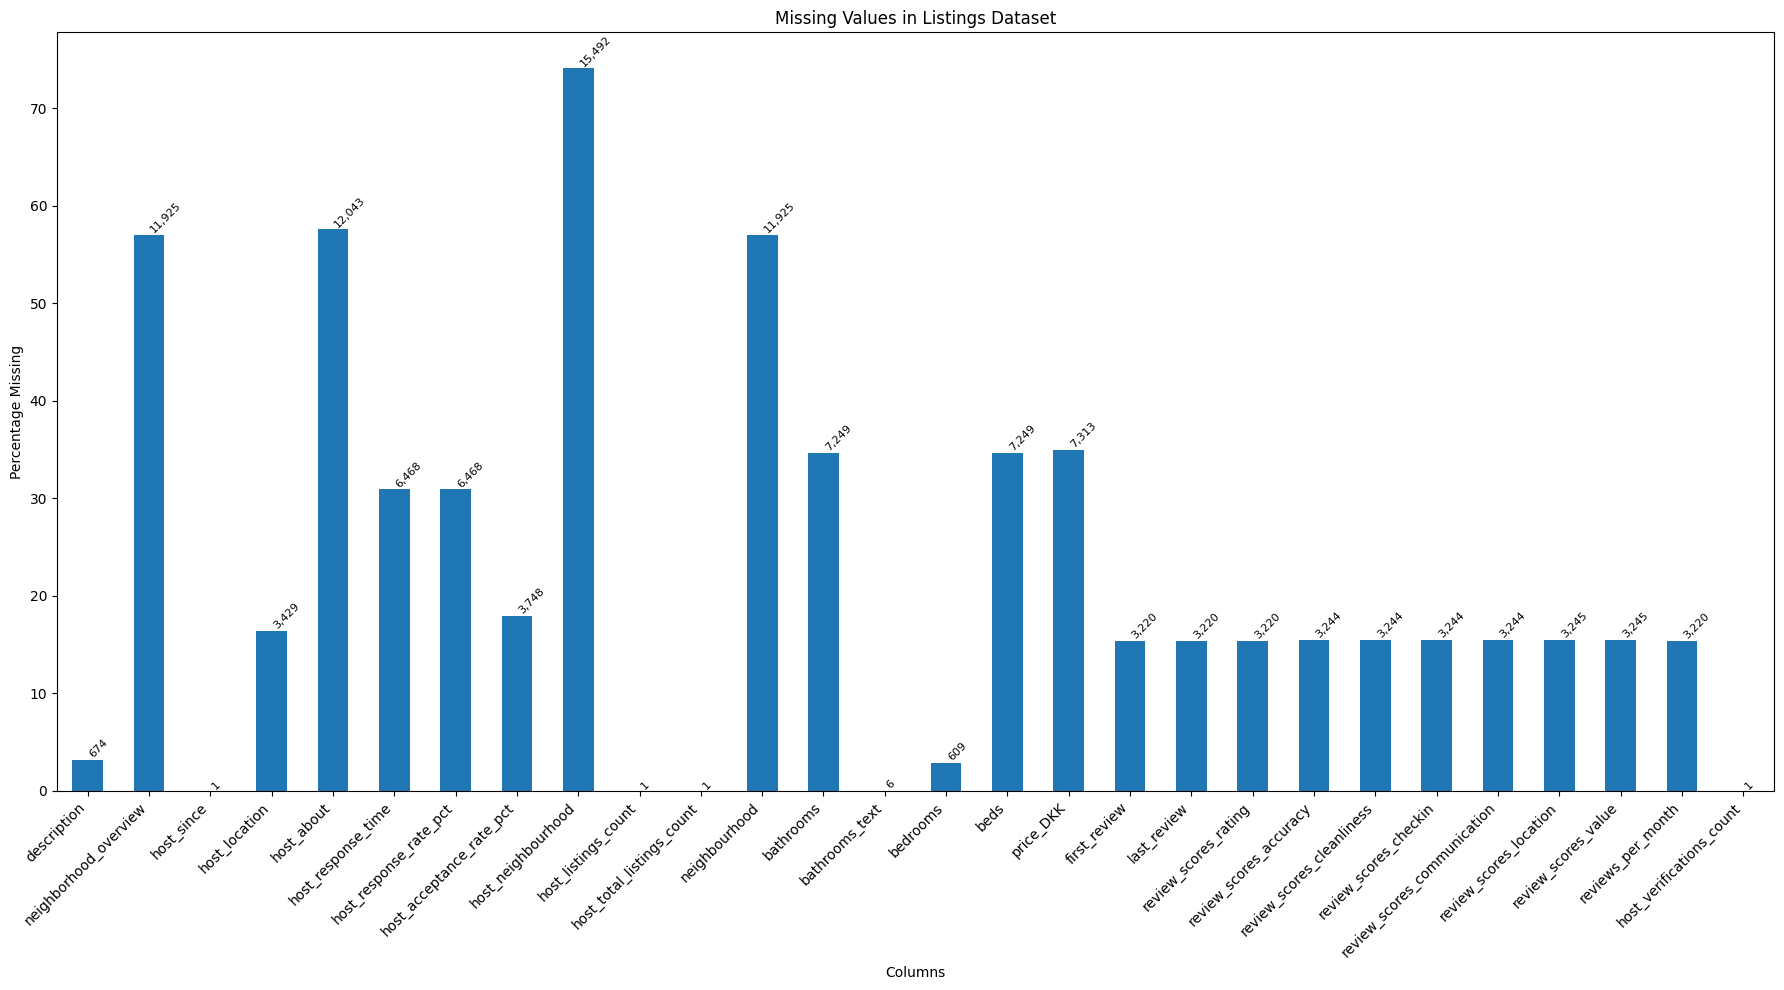

In [31]:
def plot_missing_values(missing_info, title):
    # Filter columns with more than 0.1% missing values
    missing_filtered = missing_info[missing_info['Percentage'] > 0.001]
    
    plt.figure(figsize=(18, 10))
    ax = missing_filtered['Percentage'].plot(kind='bar')
    plt.title(f'Missing Values in {title} Dataset')
    plt.xlabel('Columns')
    plt.ylabel('Percentage Missing')
    plt.xticks(rotation=45, ha='right')
    
    
    # Add total missing values labels on top of each bar, rotated 45 degrees
    for i, v in enumerate(missing_filtered['Missing Values']):
        ax.text(i, missing_filtered['Percentage'].iloc[i], f'{int(v):,}', 
                ha='left', va='bottom', fontsize=8, rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plot missing values for each dataset
plot_missing_values(listings_missing, 'Listings')
# plot_missing_values(calendar_missing, 'Calendar')
# plot_missing_values(reviews_missing, 'Reviews')

### 5. Data Quality Assessment

In [19]:
def identify_data_quality_issues(df, name):
    print(f"\n{'='*50}")
    print(f"Data Quality Report for {name}")
    print(f"{'='*50}")
    
    # 1. Check for duplicates
    n_duplicates = df.duplicated().sum()
    if n_duplicates > 0:
        print(f"\nDuplicate rows: {n_duplicates}")
    
    # 2. Check for unexpected values
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    has_unexpected = False
    for col in numeric_cols:
        n_zeros = (df[col] == 0).sum()
        n_negative = (df[col] < 0).sum()
        if n_zeros > 0 or n_negative > 0:
            if not has_unexpected:
                print("\nColumns with unexpected values:")
                has_unexpected = True
            print(f"\n{col}:")
            if n_zeros > 0:
                print(f"- Zeros: {n_zeros} ({(n_zeros/len(df))*100:.2f}%)")
            if n_negative > 0:
                print(f"- Negative values: {n_negative} ({(n_negative/len(df))*100:.2f}%)")
    
    # 3. Check string columns for data inconsistencies
    string_cols = df.select_dtypes(include=['object']).columns
    has_inconsistencies = False
    for col in string_cols:
        n_empty = (df[col] == '').sum()
        n_whitespace = df[col].str.isspace().sum() if df[col].dtype == 'object' else 0
        if n_empty > 0 or n_whitespace > 0:
            if not has_inconsistencies:
                print("\nColumns with inconsistencies:")
                has_inconsistencies = True
            print(f"\n{col}:")
            if n_empty > 0:
                print(f"- Empty strings: {n_empty}")
            if n_whitespace > 0:
                print(f"- Whitespace only: {n_whitespace}")
    
    # 4. Check for extreme values in numeric columns
    has_outliers = False
    for col in numeric_cols:
        mean = df[col].mean()
        std = df[col].std()
        outliers = df[col][abs(df[col] - mean) > 3*std]
        if len(outliers) > 0:
            if not has_outliers:
                print("\nColumns with outliers (beyond 3 std devs):")
                has_outliers = True
            print(f"\n{col}:")
            print(f"- Number of outliers: {len(outliers)}")
            print(f"- Min outlier: {outliers.min()}")
            print(f"- Max outlier: {outliers.max()}")

In [20]:
# Check Listings dataset
identify_data_quality_issues(lis_df, 'Listings')


Data Quality Report for Listings

Columns with unexpected values:

host_response_rate_pct:
- Zeros: 429 (2.05%)

host_acceptance_rate_pct:
- Zeros: 1172 (5.61%)

bathrooms:
- Zeros: 38 (0.18%)

bedrooms:
- Zeros: 164 (0.78%)

beds:
- Zeros: 1969 (9.42%)

availability_30:
- Zeros: 8689 (41.56%)

availability_60:
- Zeros: 7486 (35.80%)

availability_90:
- Zeros: 6990 (33.43%)

availability_365:
- Zeros: 5920 (28.31%)

number_of_reviews:
- Zeros: 3220 (15.40%)

number_of_reviews_ltm:
- Zeros: 6815 (32.59%)

number_of_reviews_l30d:
- Zeros: 14768 (70.63%)

calculated_host_listings_count_entire_homes:
- Zeros: 1407 (6.73%)

calculated_host_listings_count_private_rooms:
- Zeros: 18472 (88.34%)

calculated_host_listings_count_shared_rooms:
- Zeros: 20862 (99.78%)

verification_email:
- Zeros: 2191 (10.48%)

verification_phone:
- Zeros: 24 (0.11%)

verification_photographer:
- Zeros: 20908 (100.00%)

verification_work_email:
- Zeros: 19176 (91.71%)

Columns with outliers (beyond 3 std devs):


In [21]:
# Check Calendar dataset
identify_data_quality_issues(cal_df, 'Calendar')

# Additional calendar-specific checks
print("\nChecking calendar date patterns:")
cal_df['date'] = pd.to_datetime(cal_df['date'])
print(f"Date range: {cal_df['date'].min()} to {cal_df['date'].max()}")
print(f"Missing dates: {cal_df['date'].isnull().sum()}")
print(f"Days between min and max date: {(cal_df['date'].max() - cal_df['date'].min()).days}")


Data Quality Report for Calendar

Columns with outliers (beyond 3 std devs):

price_USD:
- Number of outliers: 81760
- Min outlier: 6500.0
- Max outlier: 100000.0

minimum_nights:
- Number of outliers: 45386
- Min outlier: 55.0
- Max outlier: 1111.0

Checking calendar date patterns:
Date range: 2024-06-29 00:00:00 to 2025-06-29 00:00:00
Missing dates: 0
Days between min and max date: 365


In [22]:
# Check Reviews dataset
identify_data_quality_issues(rev_df, 'Reviews')


Data Quality Report for Reviews


### 6. Data Format Analysis

In [23]:
def check_data_formats(df):
    """Check for inconsistent formats within columns"""
    for col in df.columns:
        # Get sample of unique values
        unique_samples = df[col].dropna().unique()[:2]
        print(f"\n{col}:")
        for sample in unique_samples:
            print(f"Value: {sample}, Type: {type(sample)}")


In [24]:
check_data_formats(lis_df)


id:
Value: 31094, Type: <class 'numpy.int64'>
Value: 262961, Type: <class 'numpy.int64'>

listing_url:
Value: https://www.airbnb.com/rooms/31094, Type: <class 'str'>
Value: https://www.airbnb.com/rooms/262961, Type: <class 'str'>

last_scraped:
Value: 2024-06-30 00:00:00, Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Value: 2024-06-29 00:00:00, Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>

source:
Value: previous scrape, Type: <class 'str'>
Value: city scrape, Type: <class 'str'>

name:
Value: Beautiful, spacious, central, renovated Penthouse, Type: <class 'str'>
Value: 192m2 FLAT+ 8m2 BALCONY IN CENTER NØRREBRO HOOD, Type: <class 'str'>

description:
Value: Welcome to our home, we hope you will enjoy Wonderful Copenhagen!<br /><br />Our penthouse apartment is very spacious with 164 m2 incl. a private rooftop terrasse where you can relax or grill. Despite the location in central Copenhagen, the street is very quiet and the neighbors are never heard.<br /><br />M

In [25]:
check_data_formats(cal_df)


listing_id:
Value: 586421, Type: <class 'numpy.int64'>
Value: 31094, Type: <class 'numpy.int64'>

date:
Value: 2024-06-30 00:00:00, Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Value: 2024-07-01 00:00:00, Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>

available:
Value: False, Type: <class 'numpy.bool_'>
Value: True, Type: <class 'numpy.bool_'>

price_USD:
Value: 250.0, Type: <class 'numpy.float64'>
Value: 2299.0, Type: <class 'numpy.float64'>

minimum_nights:
Value: 4.0, Type: <class 'numpy.float64'>
Value: 3.0, Type: <class 'numpy.float64'>

maximum_nights:
Value: 31.0, Type: <class 'numpy.float64'>
Value: 10.0, Type: <class 'numpy.float64'>


In [26]:
check_data_formats(rev_df)


listing_id:
Value: 31094, Type: <class 'numpy.int64'>
Value: 32379, Type: <class 'numpy.int64'>

id:
Value: 79346, Type: <class 'numpy.int64'>
Value: 166275, Type: <class 'numpy.int64'>

date:
Value: 2010-08-16 00:00:00, Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Value: 2011-01-05 00:00:00, Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>

reviewer_id:
Value: 171607, Type: <class 'numpy.int64'>
Value: 306860, Type: <class 'numpy.int64'>

comments:
Value: We had a great stay. Conveniently located, quiet and clean flat. , Type: <class 'str'>
Value: It was a very good stay. The appartment was really cosy, well located and very well equiped..., Type: <class 'str'>


### 7. Special Characters Examination

In [27]:
def check_special_characters(df):
    """Check for special characters that might need handling"""
    string_cols = df.select_dtypes(include=['object']).columns
    for col in string_cols:
        # Fixed: Properly chain the .any() method
        if df[col].astype(str).str.contains(r'[^a-zA-Z0-9\s\-.,:/+&æøåÆØÅ]').any():
            print(f"\n{col} contains special characters")
            # Show examples of rows containing special characters
            print(df[df[col].astype(str).str.contains(r'[^a-zA-Z0-9\s\-.,:/+&æøåÆØÅ]')][col].head())

In [28]:
check_special_characters(lis_df)


In [29]:
check_special_characters(cal_df)

In [30]:
check_special_characters(rev_df)